<a href="https://colab.research.google.com/github/jameszhz1647/jameszhz1647/blob/main/dataset_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle

In [3]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [1]:
!pip install albumentations==0.4.6
import albumentations 
from albumentations.pytorch import ToTensorV2

In [2]:
#Dataset for read only
import os
from xml.etree import ElementTree as et
#Data processing and data visualization with bounding boxes
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
#Global used to return all file paths with speicifc pattern
import glob
#Linear Algebra
import numpy as np # linear algebra
#Parsing HTML and XML Documents (We use the XML docs)
from bs4 import BeautifulSoup
#Model
import torchvision
from torchvision import transforms, datasets, models
import torch
# from albumentations.pytorch.transforms import ToTensorV2
import cv2

In [8]:
! kaggle datasets download andrewmvd/face-mask-detection

 99% 392M/398M [00:02<00:00, 123MB/s]
100% 398M/398M [00:03<00:00, 139MB/s]


In [11]:
! unzip face-mask-detection.zip

Archive:  face-mask-detection.zip
  inflating: annotations/maksssksksss0.xml  
  inflating: annotations/maksssksksss1.xml  
  inflating: annotations/maksssksksss10.xml  
  inflating: annotations/maksssksksss100.xml  
  inflating: annotations/maksssksksss101.xml  
  inflating: annotations/maksssksksss102.xml  
  inflating: annotations/maksssksksss103.xml  
  inflating: annotations/maksssksksss104.xml  
  inflating: annotations/maksssksksss105.xml  
  inflating: annotations/maksssksksss106.xml  
  inflating: annotations/maksssksksss107.xml  
  inflating: annotations/maksssksksss108.xml  
  inflating: annotations/maksssksksss109.xml  
  inflating: annotations/maksssksksss11.xml  
  inflating: annotations/maksssksksss110.xml  
  inflating: annotations/maksssksksss111.xml  
  inflating: annotations/maksssksksss112.xml  
  inflating: annotations/maksssksksss113.xml  
  inflating: annotations/maksssksksss114.xml  
  inflating: annotations/maksssksksss115.xml  
  inflating: annotations/maksssk

In [8]:
# might change the paths according to ur dateset directory
images_dir = '/content/images'
annotations_dir = '/content/annotations'

In [6]:
class FaceMaskDataset(torch.utils.data.Dataset):
    
    def __init__(self, images_dir, annotation_dir,width, height, transforms=None):
        self.transforms = transforms
        self.images_dir = images_dir
        self.annotation_dir = annotation_dir
        self.height = height
        self.width = width
        
        # Sorting images and checking extension filename is checked to be jpg
        self.imgs = [image for image in sorted(os.listdir(images_dir))]
        self.annotate = [image for image in sorted(os.listdir(annotation_dir))]
        
        # Classes divided into 4 with background labeled 0
        self.classes = [_, 'without_mask','with_mask','mask_weared_incorrect']

    def __getitem__(self, idx):

        img_name = self.imgs[idx]
        image_path = os.path.join(self.images_dir, img_name)

        # Reading the images    
        img = cv2.imread(image_path)
        
        # Converting size and color
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY).astype(np.float32)
        img_res = cv2.resize(img_rgb, (self.width, self.height), cv2.INTER_AREA)
        
        # Image Normalization
        img_res /= 255.0
        
        # Annotate files
        annot_filename = self.annotate[idx]
        annot_file_path = os.path.join(self.annotation_dir, annot_filename)
        
        boxes = []
        labels = []
        tree = et.parse(annot_file_path)
        root = tree.getroot()
        
        # CV2 shaping height and width sizes
        wt = img.shape[1]
        ht = img.shape[0]
        
        # Bounding box coordinates for XML files
        for member in root.findall('object'):
            labels.append(self.classes.index(member.find('name').text))
            
            # bounding box
            xmin = int(member.find('bndbox').find('xmin').text)
            xmax = int(member.find('bndbox').find('xmax').text)
            
            ymin = int(member.find('bndbox').find('ymin').text)
            ymax = int(member.find('bndbox').find('ymax').text)
            
            # Corrected for image size given
            xmin_corr = (xmin/wt)*self.width
            xmax_corr = (xmax/wt)*self.width
            ymin_corr = (ymin/ht)*self.height
            ymax_corr = (ymax/ht)*self.height
            
            boxes.append([xmin_corr, ymin_corr, xmax_corr, ymax_corr])
        
        # Convert boxes into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        
        # Getting the areas of the boxes
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])

        # Suppose all instances are not crowd
        iscrowd = torch.zeros((boxes.shape[0],), dtype=torch.int64)
        
        labels = torch.as_tensor(labels, dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["area"] = area
        target["iscrowd"] = iscrowd
        
        image_id = torch.tensor([idx])
        target["image_id"] = image_id

        if self.transforms:
            
            sample = self.transforms(image = img_res, 
                                     bboxes = target['boxes'],
                                     labels = labels)
            
            img_res = sample['image']
            target['boxes'] = torch.Tensor(sample['bboxes'])
            
        return img_res, target

    def __len__(self):
        return len(self.imgs)

In [16]:
# Checking dataset
dataset = FaceMaskDataset(images_dir, annotations_dir, 224, 224)
print('length of dataset = ', len(dataset), '\n')

# Testing image shape
img, target = dataset[1]
print('Image shape = ', img.shape, '\n','Target - ', target)

length of dataset =  853 

Image shape =  (224, 224) 
 Target -  {'boxes': tensor([[179.7600,  48.8205, 198.2400,  99.0769],
        [125.4400,  54.5641, 146.1600, 104.8205],
        [167.4400,  83.2821, 176.4000, 116.3077],
        [ 80.0800, 106.2564,  97.4400, 165.1282],
        [ 41.4400,  99.0769,  53.2000, 142.1538],
        [106.9600,  96.2051, 123.7600, 133.5385],
        [ 11.7600, 104.8205,  24.6400, 133.5385],
        [206.6400, 100.5128, 222.8800, 142.1538],
        [ 46.4800,  80.4103,  62.1600, 127.7949]]), 'labels': tensor([2, 2, 2, 2, 2, 2, 2, 2, 1]), 'area': tensor([ 928.7389, 1041.3129,  295.9095, 1022.0144,  506.5847,  627.2001,
         369.8873,  676.2504,  742.9907]), 'iscrowd': tensor([0, 0, 0, 0, 0, 0, 0, 0, 0]), 'image_id': tensor([1])}


In [10]:
#Visualizing bounding box
def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img, cmap='gray')
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Drawing the bounding box on images
        a.add_patch(rect)
    plt.show()

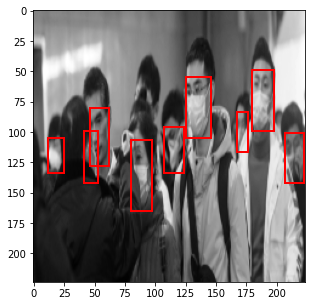

In [15]:
# Plotting bounding box on the images
img, target = dataset[1]
plot_img_bbox(img, target)